In [ ]:
pip install tsfresh

In [ ]:
import os
import pandas as pd
import numpy as np

# import ObsPy framework 

# from obspy import read
# from obspy.clients.fdsn import Client
# from obspy import UTCDateTime
# from obspy import read, Trace
# from obspy import Stream
# from obspy.clients.filesystem.sds import Client

import datetime  
import time
# import tkinter fo future use

import tkinter
from tkinter import filedialog

import matplotlib.pyplot as plt

from termcolor import colored

import scipy
from scipy import signal

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import gc
# Preset for data folders

from tensorflow.keras import regularizers
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical

from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters, EfficientFCParameters, MinimalFCParameters
from sklearn.ensemble import RandomForestClassifier

from yellowbrick.classifier.rocauc import roc_auc
from sklearn.metrics import roc_curve, auc, confusion_matrix

DATA_CAT = '20190401-20190410/20190401-20190410/'

DATA_MSD = '20190401-20190410/20190401-20190410/mseed/'

DATA_ASC = '/content/drive/MyDrive/Colab Notebooks/Data/asc20190401-20190410/'

DATA_PKS = '/content/drive/MyDrive/Colab Notebooks/Data/PKS_20190401-20190410/2021052004431722/'

DATA_RESP = '20190401-20190410/responses/'

DATA_CSV = '/content/drive/MyDrive/Colab Notebooks/Data/'

DATA_STORAGE = '/content/drive/MyDrive/Colab Notebooks/Data/'

DATA_MODEL = '/content/drive/MyDrive/'

# Disabling warnings

import warnings
warnings.filterwarnings("ignore")

header_dict = {}

df_for_learning = pd.DataFrame()
final_learning = pd.DataFrame()

RANDOM_SEED = 42

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


### Uploading file with prepared data  

In [ ]:
data = pd.read_csv(DATA_STORAGE + 'for_model.csv')
data.head()
len(data)

343229

In [ ]:
df = data.copy()

In [ ]:
# data.drop(['Unnamed: 0'], axis = 1, inplace = True)
# data = data[(data['train'] != 'train')&(data['y_filt'] != 'y_filt')&(data['time_linear'] != 'time_linear')&(data['id'] != 'id')]
# data['id'] = data['id'].apply(lambda x: int(x))
# data.isna().sum()

In [ ]:
# Cleaning function for Conv1d

def data_prep(data):
  df  = data.copy()
  df.drop(['Unnamed: 0'], axis = 1, inplace = True)
  df = df[(df['train'] != 'train')&(df['y_filt'] != 'y_filt')&(df['time_linear'] != 'time_linear')&(df['id'] != 'id')]
  marks = []
  df['train'] = df['train'].apply(lambda x: int(x))
  df['y_filt'] = df['y_filt'].apply(lambda x: float(x))
  # df['time_linear'] = df['time_linear'].apply(lambda x: pd.to_datetime(x))
  df.drop(['time_linear','id'], axis = 1, inplace = True)
  return df


In [ ]:
df = data_prep(data)

In [ ]:
# Data split for three 3 dimensions by type of event - free_of_event, P wave and S wave. The same is done for labels 
df_s = df[df['train'] == 1]['y_filt'].values
df_p = df[df['train'] == 2]['y_filt'].values
df_free = df[df['train'] == 0]['y_filt'].values
y_train = df['train'].values 

df_s.shape, df_p.shape, df_free.shape

((116033,), (73483,), (153684,))

In [ ]:
# Because of different lenght of trend they were limited by minimum value
df_s = df_s[:df_p.shape[0]]
df_free = df_free[:df_p.shape[0]]
y = y_train[:df_p.shape[0]]

In [ ]:
y = to_categorical(y)

In [ ]:
df_s = df_s.reshape(df_s.shape[0],1)
df_p = df_p.reshape(df_p.shape[0],1)
df_free = df_free.reshape(df_free.shape[0],1)

In [ ]:
# Create 3 dim array
X = np.dstack([df_s, df_p, df_free])
X.shape, y.shape

((73483, 1, 3), (73483, 3))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False, random_state=RANDOM_SEED)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((62460, 1, 3), (11023, 1, 3), (62460, 3), (11023, 3))

In [ ]:
n_timesteps, n_features, n_outputs = X_train.shape[0], X_train.shape[2], y_train.shape[1]
n_timesteps, n_features, n_outputs

(62460, 3, 3)

# Learning with Conv1D NN

### Conv1D is used for test. Lack of data making impossible to perform high quality of NN prediction. Fit/predict on basic data with (343229,) shape will not provide necessary features for network. 

In [ ]:
def evaluate_model(trainX, trainy, testX, testy):
	verbose, epochs, batch_size = 1, 50, 128
	n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
	model = Sequential()
	model.add(L.Conv1D(filters=10, kernel_size=1, activation='relu', input_shape=(n_timesteps,n_features)))
	model.add(L.Conv1D(filters=10, kernel_size=1, activation='relu'))
	model.add(L.Dropout(0.5))
	# model.add(L.MaxPooling1D(pool_size=2))
	model.add(L.Flatten())
	model.add(L.Dense(64, activation='relu'))
	model.add(L.Dense(n_outputs, activation='softmax'))
  
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  
	# fit network
	model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
	# evaluate model
	_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
	return accuracy

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
evaluate_model(X_train, y_train, X_test, y_test)


(62460, 1, 3) (11023, 1, 3) (62460, 3) (11023, 3)
Epoch 1/50
488/488 [==============================] - 2s 2ms/step - loss: 1.0485 - accuracy: 0.4736
Epoch 2/50
488/488 [==============================] - 1s 2ms/step - loss: 1.0394 - accuracy: 0.4770
Epoch 3/50
488/488 [==============================] - 1s 2ms/step - loss: 1.0389 - accuracy: 0.4771
Epoch 4/50
488/488 [==============================] - 1s 2ms/step - loss: 1.0382 - accuracy: 0.4778
Epoch 5/50
488/488 [==============================] - 1s 2ms/step - loss: 1.0381 - accuracy: 0.4780
Epoch 6/50
488/488 [==============================] - 1s 2ms/step - loss: 1.0378 - accuracy: 0.4780
Epoch 7/50
488/488 [==============================] - 1s 2ms/step - loss: 1.0378 - accuracy: 0.4780
Epoch 8/50
488/488 [==============================] - 1s 2ms/step - loss: 1.0375 - accuracy: 0.4779
Epoch 9/50
488/488 [==============================] - 1s 2ms/step - loss: 1.0378 - accuracy: 0.4780
Epoch 10/50
488/488 [=============================

0.4445250928401947

### As result we got low quality. The reason of it can be lack of initial data as (62460, 1, 3) array  

# TSFresh feature extractor

### Using of TSFresh in order to extend dataset. Based on main principal of module before start common waveform will be split for 90 numbers of different trends. It`ll make possible to create 90 rows with 15 features and 1 column for labels

In [ ]:
data = pd.read_csv(DATA_STORAGE + 'for_model.csv')
data.head()
len(data)

343229

In [ ]:
# Function for small preprocessing
def data_tsfresh(data):
  df  = data.copy()
  df.drop(['Unnamed: 0'], axis = 1, inplace = True)
  df = df[(df['train'] != 'train')&(df['y_filt'] != 'y_filt')&(df['time_linear'] != 'time_linear')&(df['id'] != 'id')]
  marks = []
  df['train'] = df['train'].apply(lambda x: int(x))
  df['y_filt'] = df['y_filt'].apply(lambda x: float(x))
  # df.drop(['time_linear'], axis = 1, inplace = True)
  df['id'] = df['id'].apply(lambda x: int(x))
  # df = df[df['train'] > 0]
  return df

In [ ]:
data_fresh = data_tsfresh(data)
id_list = set(data_fresh['id'].values)

In [ ]:
data_fresh[data_fresh['id'] == 0]

,y_filt,time_linear,train,id
0,0.002913,2019-04-01T06:40:58.884450Z,0,0
1,0.086276,2019-04-01T06:40:58.909450Z,0,0
2,-0.027060,2019-04-01T06:40:58.934450Z,0,0
3,-0.108973,2019-04-01T06:40:58.959450Z,0,0
4,0.040318,2019-04-01T06:40:58.984450Z,0,0
...,...,...,...,...
52797,0.105697,2019-04-01T23:43:09.289450Z,1,0
52798,0.225396,2019-04-01T23:43:09.314450Z,1,0
52799,-0.054952,2019-04-01T23:43:09.339450Z,1,0
52800,-0.614901,2019-04-01T23:43:09.364450Z,1,0


### # Split of waveform for different parts with individual ID for TSFresh. Overall quantity is 90 

In [ ]:

for_tsfresh = pd.DataFrame()
count = 0
for id in list(id_list):
  index_low = int(len(data_fresh[data_fresh['id'] == id])/3) # 1/3 of dataset
  index_high = int(len(data_fresh[data_fresh['id'] == id])/3) + int(len(data_fresh[data_fresh['id'] == id])/3) # 2/3 of dataset
  first = data_fresh[data_fresh['id']==id][:index_low]
  second = data_fresh[data_fresh['id']==id][index_low:index_high]
  third = data_fresh[data_fresh['id']==id][index_high:]
  first_s = first[first['train'] == 1]
  first_s['id'] = count
  first_p = first[first['train'] == 2]
  first_p['id'] = count + 1 
  first_free = first[first['train'] == 0]
  first_free['id'] = count + 2
  second_s = second[second['train'] == 1]
  second_s['id'] = count + 3
  second_p = second[second['train'] == 2]
  second_p['id'] = count + 4
  second_free = second[second['train'] == 0]
  second_free['id'] = count + 5
  third_s = third[third['train'] == 1]
  third_s['id'] = count + 6
  third_p = third[third['train'] == 2]
  third_p['id'] = count +7
  third_free = third[third['train'] == 0]
  third_free['id'] = count + 8
  for_tsfresh = for_tsfresh.append([first_s, first_p, first_free, second_s, second_p, second_free, third_s, third_p, third_free])
  count += 9

In [ ]:
for_tsfresh

,y_filt,time_linear,train,id
224,-0.110127,2019-04-01T06:41:04.484450Z,1,0
225,-0.154291,2019-04-01T06:41:04.509450Z,1,0
226,-0.105978,2019-04-01T06:41:04.534450Z,1,0
227,-0.038131,2019-04-01T06:41:04.559450Z,1,0
228,0.027139,2019-04-01T06:41:04.584450Z,1,0
...,...,...,...,...
343022,-2.442529,2019-04-10T20:33:59.969500Z,0,89
343023,-0.690547,2019-04-10T20:33:59.994500Z,0,89
343024,1.750333,2019-04-10T20:34:00.019500Z,0,89
343025,2.988089,2019-04-10T20:34:00.044500Z,0,89


In [ ]:
def featuresTSFresh(data, N):    
    global featuresDF
    ## список фич (см. документацию по TSFresh: https://media.readthedocs.org/pdf/tsfresh/latest/tsfresh.pdf)
    extraction_settings = \
    {
        ## признак: параметр
        "maximum": None,
        "mean": None,
        "minimum": None,
        "median": None,
        "standard_deviation": None,
        "binned_entropy": [{"max_bins" : 10}],
        "count_above_mean": None,
        "count_below_mean": None,
        "first_location_of_maximum": None,
        "first_location_of_minimum": None,
        "mean_change": None,
        "sum_values": None,
        "kurtosis": None,
        "skewness": None,
        "abs_energy": None        
    }

    ## извлечение фич из данных    
    featuresDF = extract_features(
        data, 
        column_id='id',  ## номер временного ряда
        column_sort='time_linear', ## ось времени
        default_fc_parameters=extraction_settings, ## список фич, которые хотим извлечь
        impute_function=impute                     ## заменить все inf и NaN
    )
    
    ## вытаскиваем колонку id из индекса 
    featuresDF = featuresDF.reset_index()
    featuresDF['label'] = N
    print('Label: ', N)
    # featuresDF = featuresDF.append(featuresDF)
    featuresDF.to_csv('features_2.csv', mode = 'a') 
    !cp features_2.csv "/content/drive/MyDrive/Colab Notebooks/Data/"
    return featuresDF

## убираем колонку class из данных (мы не хотим из неё извлекать фичи)
# features = featuresTSFresh(df_s, 1)
# features = featuresTSFresh(df_p, 2)
# features = featuresTSFresh(df_free, 0)
## помечаем ряды (добавляем обратно первый и второй класс)
# features['label'] = 0
# features['label'].iloc[N:] = 1

# print('data.shape =', df.shape)
# print('features.shape =', features.shape)
# features.head(3)

In [ ]:
data_tsfresh = pd.DataFrame()
for N in list(set(for_tsfresh['train'].values)):
  intermediate_df = for_tsfresh[for_tsfresh['train'] == N]
  temp = featuresTSFresh(intermediate_df.drop('train', axis = 1), N)
  
 
  

Feature Extraction: 100%|██████████| 5/5 [00:00<00:00, 22.79it/s]


Label:  0


Feature Extraction: 100%|██████████| 5/5 [00:00<00:00, 28.21it/s]


Label:  1


Feature Extraction: 100%|██████████| 5/5 [00:00<00:00, 35.96it/s]


Label:  2


## Uploading data from TSFresh

In [ ]:
data = pd.read_csv(DATA_STORAGE + 'features_2.csv')
data.drop(['Unnamed: 0','index'], axis = 1, inplace = True)
data = data[data['y_filt__maximum'] != 'y_filt__maximum']
for col in data.columns:
  data[col] = data[col].astype(float)

# data.info()

In [ ]:
data.head(3)

,y_filt__maximum,y_filt__mean,y_filt__minimum,y_filt__median,y_filt__standard_deviation,y_filt__binned_entropy__max_bins_10,y_filt__count_above_mean,y_filt__count_below_mean,y_filt__first_location_of_maximum,y_filt__first_location_of_minimum,y_filt__mean_change,y_filt__sum_values,y_filt__kurtosis,y_filt__skewness,y_filt__abs_energy,label
0,17.0727052061,-0.0016761967477931141,-20.1820701821,-0.000287374222316,1.1268462992545594,0.13413748333190087,4457.0,4137.0,0.9570630672562253,0.9575285082615779,-1.9173999200160594e-05,-14.405234850534022,110.15516560321583,-1.20658817083739,10912.53565695073,0
1,17.0330512798,0.0023291533930377036,-17.9107089343,-0.000153610906673,1.352281497878664,0.2176565719307299,3962.0,4474.0,0.9506875296348981,0.9210526315789473,-1.7399251904090104e-05,19.648738023666066,65.51326292961417,0.12096006878147043,15426.665809748705,0
2,60.5251231416,-0.0008036833609931928,-51.3611012316,6.3604847248e-05,4.671329033153107,0.27925550391251625,4077.0,3925.0,0.8555361159710072,0.8562859285178706,7.271694866062991e-05,-6.431074254667529,52.64369256022764,0.12352230441648879,174614.1672862525,0


In [ ]:
df_s = data[data['label'] == 1].drop(['label'], axis = 1)
df_p = data[data['label'] == 2].drop(['label'], axis = 1)
df_free = data[data['label'] == 0].drop(['label'], axis = 1)
y_train = data['label'].values 
y = to_categorical(y_train)

In [ ]:
df_s.shape, df_p.shape, df_free.shape, y.shape

((60, 15), (60, 15), (60, 15), (180, 3))

In [ ]:
df_s = data[data['label'] == 1].drop(['label'], axis = 1).values
df_p = data[data['label'] == 2].drop(['label'], axis = 1).values
df_free = data[data['label'] == 0].drop(['label'], axis = 1).values
y_s = data[data['label'] == 1]['label'].values
y_p = data[data['label'] == 2]['label'].values
y_free = data[data['label'] == 0]['label'].values
# y = to_categorical(y_train)

# Random Forest Classifier

### As a main model RandomForest classifier will be used with multiclass fit/prediction

In [ ]:
# For data upload slice must be used because by mistake data was uploaded to file twice.
data = pd.read_csv(DATA_STORAGE + 'features_2.csv')[:94]
data.drop(['Unnamed: 0','index'], axis = 1, inplace = True)
data = data[data['y_filt__maximum'] != 'y_filt__maximum']
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91 entries, 0 to 93
Data columns (total 16 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   y_filt__maximum                      91 non-null     object
 1   y_filt__mean                         91 non-null     object
 2   y_filt__minimum                      91 non-null     object
 3   y_filt__median                       91 non-null     object
 4   y_filt__standard_deviation           91 non-null     object
 5   y_filt__binned_entropy__max_bins_10  91 non-null     object
 6   y_filt__count_above_mean             91 non-null     object
 7   y_filt__count_below_mean             91 non-null     object
 8   y_filt__first_location_of_maximum    91 non-null     object
 9   y_filt__first_location_of_minimum    91 non-null     object
 10  y_filt__mean_change                  91 non-null     object
 11  y_filt__sum_values                   91 non-nul

In [ ]:
dataset = data.copy()
print(dataset.shape)

(91, 16)


In [ ]:
factor = pd.factorize(dataset['label'])
dataset.species = factor[0]
definitions = factor[1]
print(dataset.label.head())
print(definitions)


0    0
1    0
2    0
3    0
4    0
Name: label, dtype: object
Index(['0', '1', '2'], dtype='object')


In [ ]:
#Splitting the data into independent and dependent variables
X = dataset.iloc[:,0:15].values
y = dataset.iloc[:,15].values
print('The independent features set: ')
print(X[:2,:])
print('The dependent variable: ')
print(y[:5])

The independent features set: 
[['17.0727052061' '-0.0016761967477931141' '-20.1820701821'
  '-0.000287374222316' '1.1268462992545594' '0.13413748333190087'
  '4457.0' '4137.0' '0.9570630672562253' '0.9575285082615779'
  '-1.9173999200160594e-05' '-14.405234850534022' '110.15516560321583'
  '-1.20658817083739' '10912.53565695073']
 ['17.0330512798' '0.0023291533930377036' '-17.9107089343'
  '-0.000153610906673' '1.352281497878664' '0.2176565719307299' '3962.0'
  '4474.0' '0.9506875296348981' '0.9210526315789473'
  '-1.7399251904090104e-05' '19.648738023666066' '65.51326292961417'
  '0.12096006878147043' '15426.665809748705']]
The dependent variable: 
['0' '0' '0' '0' '0']


In [ ]:
# Creating the Training and Test set from data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 4, 'max_features' : 1, 'class_weight' : 'balanced',
         'random_state': 42}

In [ ]:
# Fitting Random Forest Classification on the training set
classifier = RandomForestClassifier(n_estimators = 1000, max_depth=4, max_features='auto', min_samples_split = 2, criterion = 'entropy', random_state = 42)
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)
reversefactor = dict(zip(range(3),definitions))
# Making the Confusion Matrix
print(pd.crosstab(y_test, y_pred, rownames=['Actual classes'], colnames=['Predicted Species']))

Predicted Species  0  1  2
Actual classes            
0                  6  3  1
1                  4  3  1
2                  1  1  8


### The TP/TN table above shows how many predictions are correct. Average accuraccy ~82% 

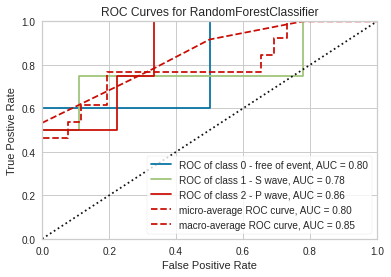

In [ ]:
from yellowbrick.classifier.rocauc import roc_auc
roc_auc(classifier, X_train, y_train, X_test=X_test, y_test=y_test, classes=['0 - free of event', '1 - S wave','2 - P wave'])

# END

trainSet.shape = (72, 16)
testSet.shape  = (48, 16)

Value counts train:
 2    37
1    35
Name: label, dtype: int64

Value counts test:
 1    25
2    23
Name: label, dtype: int64


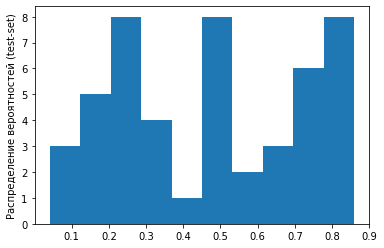

                               features  importances
12                     y_filt__kurtosis     0.085132
4            y_filt__standard_deviation     0.080464
0                       y_filt__maximum     0.079133
9     y_filt__first_location_of_minimum     0.078614
13                     y_filt__skewness     0.073497
14                   y_filt__abs_energy     0.068057
5   y_filt__binned_entropy__max_bins_10     0.067344
11                   y_filt__sum_values     0.066201
2                       y_filt__minimum     0.064795
3                        y_filt__median     0.061153
7              y_filt__count_below_mean     0.059811
6              y_filt__count_above_mean     0.057195
10                  y_filt__mean_change     0.054035
8     y_filt__first_location_of_maximum     0.052638
1                          y_filt__mean     0.051930

   Pos  Neg
0   20    5
1    4   19

AUC = 0.951  Точность = 0.812



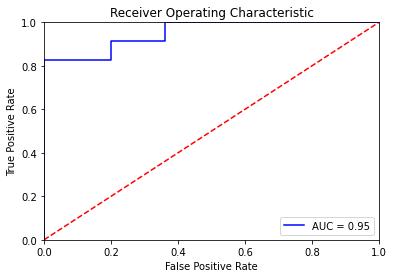

In [ ]:
# ## разбиваем выделенные фичи на тренировочный и тестовый наборы 
# # trainSet, testSet = train_test_split(features, test_size=0.4, random_state=42) 

# ## выводим статистику по нашим наборам
# print('trainSet.shape =', trainSet.shape)
# print('testSet.shape  =', testSet.shape)
# print()
# print('Value counts train:\n', trainSet.label.value_counts())
# print()
# print('Value counts test:\n', testSet.label.value_counts())

# ## лист фич
# featureList = trainSet.drop(['label'], axis=1).columns

# ## параметры классификатора
# params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 4, 'max_features' : 1, 'class_weight' : 'balanced',
#          'random_state': 42}

# ## обучаем классификатор
# clf = RandomForestClassifier(**params).fit(trainSet[featureList], trainSet['label'])

# ## делаем предсказание на тестовом наборе
# y_pred = clf.predict(testSet[featureList])
# y_pred_proba = clf.predict_proba(testSet[featureList])[:,1]  ## вероятности

# ## визуализируем вероятности для предсказаний
# import matplotlib.pyplot as plt
# plt.hist(y_pred_proba)
# plt.ylabel('Распределение вероятностей (test-set)')
# plt.show()



# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import roc_curve, auc
# from math import isnan

# ## создадим для удобства дейтафрейм с результатами
# res = testSet
# res['pred'] = y_pred 
# res['pred_proba'] = y_pred_proba

# ## получаем из классификатора важность фич и отображаем их
# ftmprt = pd.DataFrame()
# ftmprt['features'] = featureList
# ftmprt['importances'] = clf.feature_importances_
# ftmprt = ftmprt.sort_values('importances', ascending=False)
# print(ftmprt.head(20))
# print()
# proba = res.pred_proba

# ## считаем матрицу ошибок
# CM = confusion_matrix(res['label'], res['pred'])
# CM_DF = pd.DataFrame(data=CM, columns = ['Pos', 'Neg'])
# print(CM_DF)

# # ROC-AUC 
# FPR, TPR, thresholds = roc_curve(res['label'], res['pred_proba'],pos_label=2)
# roc_auc = auc(FPR, TPR)
# acc = res[res['pred'] == res['label']].shape[0] / res.shape[0] ## точность
# print(f"\nAUC = {roc_auc:.3f}  Точность = {acc:.3f}\n")

# # ROC-кривая
# plt.title('Receiver Operating Characteristic')
# plt.plot(FPR, TPR, 'b', label=f'AUC = {roc_auc:.2f}')
# plt.legend(loc='lower right')
# plt.plot([0, 1], [0, 1], 'r--')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show()

# _____________________________